In [1]:
from typing import List, Dict, Tuple
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from yolov5.utils.datasets import create_dataloader

# 1. Visual inspection

In [2]:
dataloader, dataset = create_dataloader(
    path='data/splits/all_imgs.txt',
    imgsz=1280,
    batch_size=10,
    stride=1,
    rect=True,
    workers=4
)

dataloader_it = iter(dataloader)
batch = next(dataloader_it)

Scanning 'data/splits/all_imgs.cache' images and labels... 19362 found, 0 missing, 0 empty, 23 corrupted: 100%|██████████| 19362/19362 [00:00<?, ?it/s]


In [3]:
def display_instances(batch: Tuple, labels: List, colors: List,
                      ncols: int = 2, figsize: Tuple[int] = (15, 20)):
    imgs, targets, *_ = batch
    n_imgs = imgs.shape[0]
    
    height, width = imgs.shape[2:]
    targets = targets.numpy().copy()
    targets[:, [2, 4]] *= width
    targets[:, [3, 5]] *= height
    
    nrows = int(np.ceil(n_imgs / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    odd_axes = nrows * ncols - n_imgs
    for i in range(odd_axes):
        fig.delaxes(axes[-(i + 1)])
    
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')
        
        bboxes = targets[targets[:, 0] == i][:, 1:]
        for label_id, xc, yc, w, h in bboxes:
            x, y = xc - w/2, yc - h/2
            color = colors[int(label_id)]
            rec = Rectangle((x, y), w, h, facecolor='none', 
                            edgecolor=color)
            ax.add_patch(rec)
            ax.text(x, y, labels[int(label_id)], color=color, size=9)

    fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)

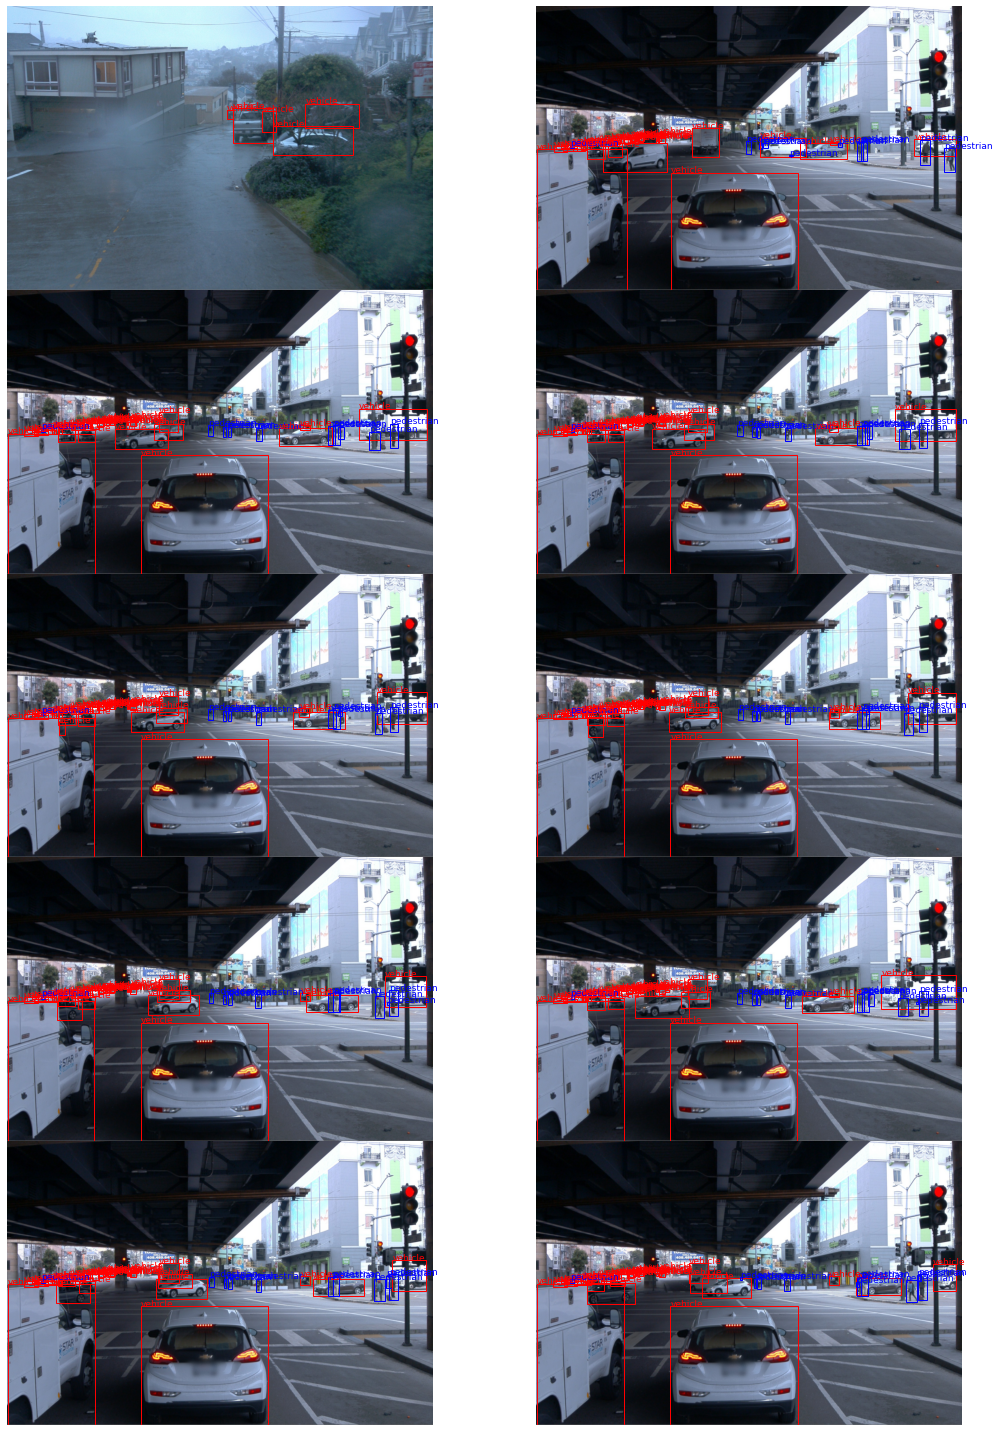

In [4]:
labels = ['vehicle', 'pedestrian', 'cyclist']
colors = ['red', 'blue', 'green']

display_instances(batch, labels, colors)

# 2. Additional EDA

Let's load dataframe with bbox descriptions:

In [5]:
df = pd.read_pickle('data/df_annotations.pkl')

In [6]:
label_map = dict(enumerate(labels))
df['label'] = df.category_id.map(label_map)

df['source_file_id'] = df.image_path.str.extract('/([0-9_]+)/', expand=False)

In [7]:
df[:5]

,image_path,image_id,height,width,category_id,...,ymax,scale,aspect_ratio,label,source_file_id
0,/workspace/project/data/images/109649566170275...,10964956617027590844_1584_680_1604_680/0,1280,1920,0,...,0.162832,0.153694,0.890909,vehicle,10964956617027590844_1584_680_1604_680
1,/workspace/project/data/images/109649566170275...,10964956617027590844_1584_680_1604_680/1,1280,1920,0,...,0.162832,0.153345,0.886869,vehicle,10964956617027590844_1584_680_1604_680
2,/workspace/project/data/images/109649566170275...,10964956617027590844_1584_680_1604_680/2,1280,1920,0,...,0.162832,0.152995,0.882828,vehicle,10964956617027590844_1584_680_1604_680
3,/workspace/project/data/images/109649566170275...,10964956617027590844_1584_680_1604_680/3,1280,1920,0,...,0.162832,0.154389,0.898990,vehicle,10964956617027590844_1584_680_1604_680
4,/workspace/project/data/images/109649566170275...,10964956617027590844_1584_680_1604_680/4,1280,1920,0,...,0.162832,0.154562,0.901010,vehicle,10964956617027590844_1584_680_1604_680


In [8]:
df.shape

(458997, 13)

In [9]:
print(
    f'There are {df.image_id.nunique()} images in {df.source_file_id.nunique()} source files'
)

There are 19362 images in 100 source files


## 2.1 Bbox geometry

### scale distribution

In [11]:
df['scale_abs'] = np.sqrt(df.scale**2 * df.width * df.height)

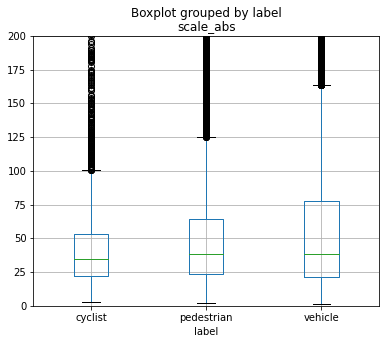

In [12]:
df.boxplot('scale_abs', 'label', figsize=(6,5))

plt.ylim(0, 200);

In [13]:
q = 0.99
print(f'{q}-th quantile for scale: {int(df.scale_abs.quantile(q))} squared pixels')

0.99-th quantile for scale: 468 squared pixels


### aspect ratio distribution

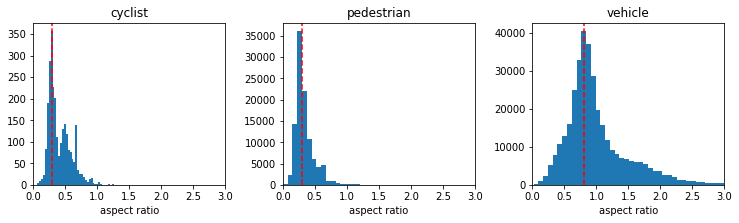

In [14]:
upper_thr = 3
filt = df.aspect_ratio < upper_thr
axes = df[filt].hist('aspect_ratio', 'label', bins=40, rot=0,
                     layout=(1,3), figsize=(12,3))
axes = axes.flatten()

peaks = [0.3, 0.3, 0.8]

for ax, peak in zip(axes, peaks):
    ax.axvline(peak, c='red', ls='--')
    ax.set_xlim(0, upper_thr)
    ax.set_xlabel('aspect ratio')

In [15]:
q = 0.99
print(f'{q}-th quantile for aspect ratio: {df.aspect_ratio.quantile(q).round(1)}')

0.99-th quantile for aspect ratio: 2.7


## 2.2 Class balance

There's a heavy class disbalance not in favour of 'cyclist', which means
1. this class will be the hardest to train
2. we should make sure it's represented in every split (and the quantity is somewhat sufficient)

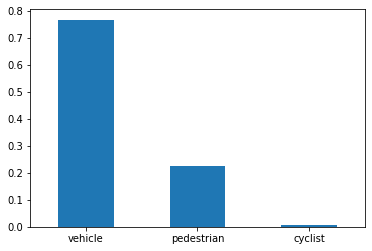

In [16]:
label_count = df.label.value_counts()
label_distr = label_count / label_count.sum()

assert np.allclose(label_distr.sum(), 1)

label_distr.plot.bar(rot=0);

In [17]:
label_count

vehicle       352694
pedestrian    103664
cyclist         2639
Name: label, dtype: int64

In [18]:
(label_distr * 100).round(2)

vehicle       76.84
pedestrian    22.58
cyclist        0.57
Name: label, dtype: float64

What is more, 'cyclist' presence across files is very skewed, which suggests we should not rely on random cross-val splits, but rather stratify them by this class.

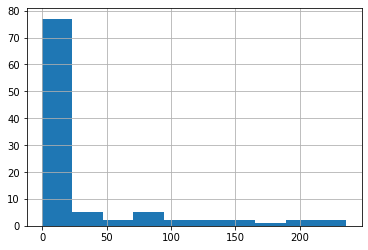

In [19]:
labels_per_file = df.groupby(['source_file_id', 'label']) \
                    .size().unstack(fill_value=0)
cyclists_per_file = labels_per_file.cyclist

cyclists_per_file.hist();

In [20]:
zero_share = int(100 * (cyclists_per_file == 0).mean())

print(f'{zero_share}% of source files have 0 cyclists')

73% of source files have 0 cyclists


## 2.3 Other observations about source TFR files

There're almost always roughly 200 images per file, so it's safe to split by files and expect the same ratio in terms of image quantities.

(180.0, 210.0)

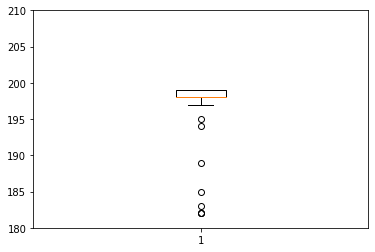

In [21]:
images_per_file = df.groupby('source_file_id').image_id.nunique()

plt.boxplot(images_per_file);
plt.ylim(180, 210)

It's clearly seen, that images in TFR files are consecutive snapshots, which implies that cross-val split should be conducted by source files to ensure diversity between splits.

# 3. Cross-val split

Now I think it would be safe to make random splits by source files with stratification by 'cyclist' class.<br>
To use cyclists count per file as stratification feature, we need to discretize it.

In [22]:
cyclists_per_file_discr = pd.qcut(cyclists_per_file, [0, 0.73, 0.85, 1])

assert cyclists_per_file_discr.notnull().all()

In [23]:
file_ids = sorted(df.source_file_id.unique())
cyclists_per_file_discr = cyclists_per_file_discr[file_ids]

In [24]:
train_file_ids, test_file_ids = train_test_split(file_ids, train_size=0.85, random_state=3,
                                                 stratify=cyclists_per_file_discr)

train_file_ids, val_file_ids = train_test_split(train_file_ids, test_size=0.11, random_state=3,
                                                stratify=cyclists_per_file_discr[train_file_ids] )

len(train_file_ids), len(val_file_ids), len(test_file_ids)

(75, 10, 15)

Now after we got lists of file ids per split, we map them to dataframe.

In [25]:
df['split'] = None

df.loc[df.source_file_id.isin(train_file_ids), 'split'] = 'train'
df.loc[df.source_file_id.isin(val_file_ids), 'split'] = 'val'
df.loc[df.source_file_id.isin(test_file_ids), 'split'] = 'test'

assert df.split.notnull().all()

Checking number of images in each split:

In [26]:
df.groupby('split').image_id.nunique().sort_values()[::-1]

split
train    14515
test      2881
val       1966
Name: image_id, dtype: int64

Let's make sure we are happy with resulting class distributions.

In [27]:
split_label_count = df.groupby(['label', 'split']).size().unstack() \
                      .sort_values('test')[::-1]
split_label_count

split,test,train,val
label,,,
vehicle,60667,254940,37087
pedestrian,15638,72750,15276
cyclist,296,2039,304


In [28]:
split_label_distr = 100 * split_label_count / split_label_count.sum()
split_label_distr.round(1)

split,test,train,val
label,,,
vehicle,79.2,77.3,70.4
pedestrian,20.4,22.1,29.0
cyclist,0.4,0.6,0.6


Although it may seem like the other 2 classes are distributed unevenly across splits, I found it impossible to balance all the 3 simultaneously, so I will go with this split.
Finally, we should dump resulting splits to disk.

In [29]:
for split in ['train', 'val', 'test']:
    image_paths = df.query("split == @split").image_path.unique()
    with open(f'data/splits/{split}_imgs.txt', 'w') as fid:
        fid.write('\n'.join(image_paths))